## 모델_2 ALBERT
- 메켑미적용 
- 불용어 포함
- 워드피스토큰화 
- ALBERT모델 적용

==> 마디별로 사전학습토큰모델로 워드피스 토큰화한것이다.

In [1]:
#코랩 실행시 주석해체
# !pip install tokenizers
# !pip install transformers
# !pip install konlpy
# !pip install soynlp

In [2]:
import re
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from collections import Counter
from transformers import BertTokenizerFast
from sklearn.preprocessing import LabelEncoder
from soynlp.normalizer import repeat_normalize
from sklearn.feature_extraction.text import TfidfVectorizer

#모델
from transformers import TFAlbertForSequenceClassification
from transformers import AlbertConfig
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

#필요없는 경고무시
import warnings
warnings.filterwarnings('ignore')

#시각화용 임포트 모음
import seaborn as sns
import matplotlib.pyplot as plt
from plotly import graph_objs as go

In [3]:
# xlsx 파일 읽기
df_train = (pd.read_excel('./kor_emotion.xlsx')).iloc[:,:2]
display(df_train.head())
display(df_train.info())

#널값있는지 확인
empty_string_exists = any(list(map(lambda x, y: x == "" or y == "", df_train['Sentence'], df_train['Emotion'])))

if empty_string_exists:
    print("널값이 존재합니다.")
    df_train[{'Sentence','Emotion'}].replace('', np.nan, inplace=True)
    df_train.dropna( inplace=True)
    print("널값 제거하였습니다.")
else:
    print("널값이 없습니다.")

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요..??,공포
1,그냥 내 느낌일뿐겠지?,공포
2,아직너무초기라서 그런거죠?,공포
3,유치원버스 사고 낫다던데,공포
4,근데 원래이런거맞나요,공포


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38594 entries, 0 to 38593
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  38594 non-null  object
 1   Emotion   38594 non-null  object
dtypes: object(2)
memory usage: 603.2+ KB


None

널값이 없습니다.


In [5]:
#Emotion 분포 확인
df_train['Emotion'].unique()
df_train['Emotion'].value_counts()
df_emotion= df_train.groupby('Emotion').count().reset_index().sort_values(by='Sentence', ascending=False)
df_emotion.style.background_gradient(cmap='Purples')

,Emotion,Sentence
5,행복,6037
1,놀람,5898
2,분노,5665
0,공포,5468
6,혐오,5429
3,슬픔,5267
4,중립,4830


In [130]:
df_train[df_train['Sentence'].apply(len)>=55]

,Sentence,Emotion
18,마지막에 말씀 드렸던대로 글은 이제 내릴게요의도치않게 실시간베스트글에 올라가서 남친...,공포
94,안올것같기도하고...주위에서 세상에 남자는많다라고하는데..제몸하나 쓰담어주는남자는 ...,공포
230,"물론 시즌말에 가서 떨어질꺼라 예상은 했다만,스크는 나름대로 잘 나가다가 왜 성적이...",공포
358,저는 초등학교 6학년이고 제가 5학년이 제가무섭다는 소문도 듣고 날라리라는 이야기를...,공포
375,이런 생각이나 할텐데자기를 음란하게 생각할텐데누가 자기 다리 쳐다보는건 싫어하면서...,공포
...,...,...
38482,이 기사에 적어도 오타가 10개이상 났는데 아무도 지적 안하는거 보니 제목만 읽은 ...,혐오
38492,조선시대 묵힌정책을하며세금은 시대를 반영하며 천정부지로 올리며서민은 구닥다리 인생에...,혐오
38493,댓글은 듣보잡이라 놓고 어마어마한 댓글수ㅋ이미 톱스타 됐다는건 니들이 증명해주고 있...,혐오
38501,기춘아 너로 인해 죽은사람들 지금도 고통받는 가족들한테 사죄하면서 남은여생 차가운골...,혐오


리뷰의 최대 길이 : 299
리뷰의 평균 길이 : 23.720526506710886


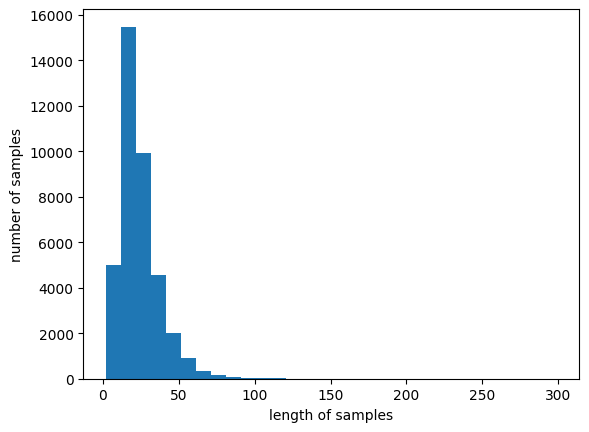

55


In [131]:
# 감성 단어 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in df_train['Sentence']))
print('리뷰의 평균 길이 :',sum(map(len, df_train['Sentence']))/len(df_train['Sentence']))
plt.hist([len(review) for review in df_train['Sentence']], bins=30)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()


# 리뷰의 97%를 포함하는 길이
max_length = int(df_train['Sentence'].str.len().quantile(0.97))
print(max_length)
#너무 긴 문장 잘라내기
df_train['Sentence'] = df_train['Sentence'].apply(lambda x : x[:max_length])


word piece시작

In [132]:
tokenizer = BertTokenizerFast.from_pretrained("kykim/albert-kor-base")

# BertTokenizerFast 객체를 피클로 저장
with open('./albert_tokenizer.pkl', "wb") as f:
    pickle.dump(tokenizer, f)


#리스트형태로 입력된다.
train_encodings = tokenizer(
    df_train['Sentence'].tolist(),
    truncation=True,
    padding='max_length',
    max_length=32,
    return_token_type_ids= False
) 


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizerFast'. 
The class this function is called from is 'BertTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizerFast'. 
The class this function is called from is 'BertTokenizerFast'.


In [133]:
train_encodings.keys()

dict_keys(['input_ids', 'attention_mask'])

In [134]:
#데이터확인
#수치형 데이터
print(train_encodings['input_ids'][10035])
#토큰화된 텍스트
print(tokenizer.convert_ids_to_tokens(train_encodings['input_ids'][10035]))
#원본텍스트
print(tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(train_encodings['input_ids'][10035])))

[2, 26902, 4242, 16452, 14661, 2033, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['[CLS]', '결혼을', '뭐', '##하러', '하지', '?', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
[CLS] 결혼을 뭐하러 하지? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


## 모델 시작

albert config
{
  "attention_probs_dropout_prob": 0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0,
  "embedding_size": 128,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_hidden_groups": 1,
  "net_structure_type": 0,
  "gap_size": 0,
  "num_memory_blocks": 0,
  "inner_group_num": 1,
  "down_scale_factor": 1,
  "type_vocab_size": 2,
  "vocab_size": 30000
}

In [135]:
# 행을 무작위로 섞은 새 DataFrame 생성
df_train= df_train.sample(frac=1).reset_index(drop=True)
df_train.head()

,Sentence,Emotion
0,남자나 여자나 둘다 정상은 아닌듯...,놀람
1,구속시켜라 저렇게 죄를 지었고 법원은 개만도 못한 인간들만 았단말인가???????,분노
2,사도스키 서현진 ㄷㄷㄷ,놀람
3,아직 공소시효 안지났다..,분노
4,이때까지 낸 기록을 보세염...,놀람


In [136]:
# 입력 데이터로 변환
train_input_ids = np.array(train_encodings['input_ids'])
train_attention_mask = np.array(train_encodings['attention_mask'])

#라벨인코딩 실행
label_encoder =LabelEncoder()
encoded_target = label_encoder.fit_transform(df_train['Emotion'])
label_encoder.classes_
df_train['encoded_target'] = encoded_target

train_labels = np.array(df_train['encoded_target'].tolist())


array([1, 2, 1, 2, 1, 1, 3, 1, 6, 2, 1, 0, 4, 6, 2, 6, 4, 3, 5, 4, 5, 2,
       3, 0, 0, 1, 6, 6, 5, 0, 1, 3, 6, 1, 1, 5, 0, 0, 5, 5, 0, 3, 0, 4,
       5, 1, 4, 1, 1, 1, 1, 3, 4, 6, 2, 2, 1, 1, 2, 5, 5, 4, 4, 5, 3, 1,
       3, 3, 6, 2, 2, 5, 4, 0, 3, 1, 3, 6, 0, 4, 6, 6, 2, 6, 1, 0, 6, 5,
       5, 2, 6, 3, 5, 5, 3, 0, 2, 5, 4, 1])

In [138]:
# 모델 구성 정의
config = AlbertConfig.from_pretrained("kykim/albert-kor-base")
config.num_hidden_layers = 12  # 레이어 수 변경
config.num_attention_heads = 12  #헤드수 변경
config.hidden_dropout_prob =0.2
config.hidden_size = 420  # 히든 사이즈 변경
config.num_labels = 7
config.intermediate_size = 2832

#모델 정의
albert_model = TFAlbertForSequenceClassification(config=config)


# 모델 컴파일
optimizer = tf.keras.optimizers.Adam(learning_rate = 4e-5, epsilon=1e-08)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

albert_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
)
early_stop=tf.keras.callbacks.EarlyStopping(
    monitor='accuracy',
    patience=5,
    restore_best_weights=True
)
# reduceLr = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=7)

In [140]:
#모델 빌드 
# 샘플 입력 데이터 생성
sample_input_ids = train_input_ids[:1]
sample_attention_mask = train_attention_mask[:1]

# 샘플 입력 데이터를 사용하여 모델을 호출하고 빌드
albert_model((sample_input_ids, sample_attention_mask))

TFSequenceClassifierOutput(loss=None, logits=<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
array([[ 0.16487868, -0.03208205, -0.15410249, -0.13538739,  0.16384697,
         0.0313354 , -0.03187834]], dtype=float32)>, hidden_states=None, attentions=None)

In [141]:
albert_model.summary()

Model: "tf_albert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 albert (TFAlbertMainLayer)  multiple                  8725552   
                                                                 
 dropout_4 (Dropout)         multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2807      
                                                                 
Total params: 8,728,359
Trainable params: 8,728,359
Non-trainable params: 0
_________________________________________________________________


In [142]:
# 모델 훈련
albert_model.fit(
    [train_input_ids, train_attention_mask],
    train_labels,
    batch_size=64,
    epochs=24,
    callbacks=[early_stop],
    # shuffle=True,
)

NameError: name 'train_labels' is not defined

In [ ]:
#모델 저장# 폴더안에 가중치(json)와 함께 저장된다.
albert_model.save_pretrained('./emo-classfier_albert-kor-base')